# REST API for PACO server


The docs is available at http://localhost:8080/docs or at [docs](http://localhost:8080/docs) 

In [4]:
#################
# IMPORTS
#################
import requests
import getpass
import re
import random
import string
from IPython.display import display, SVG
#################
# HEADERS
#################
headers = {
    "Content-Type": "application/json",
}
url = "http://127.0.0.1:8000/"

## Define the *BPMN+CPI*

In the following cell the *BPMN+CPI* is defined. 
 - expression: A string representing the BPMN expression, which defines the sequence and parallelism of tasks.
 - impacts: A dictionary where keys are task names and values are lists of impacts (e.g., costs, durations).
 - durations: A dictionary where keys are task names and values are lists representing the duration range [min, max] for each task.
 - probabilities: A dictionary where keys are natures (e.g., 'N1') and values are their probabilities.
 - loop_round: A dictionary for defining loop rounds, if any.
 - names: A dictionary mapping event names to their string representations that are displayed when the bpmn is drawn.
 - delays: A dictionary where keys are event names (e.g., 'C1') and values are their delays.
 - loop_probability: A dictionary for defining loop probabilities, if any.
 - impacts_names: A list of impact names (e.g., ['cost_electricity']).

In [5]:
bpmn = {
    "expression": "(Cutting, ((Bending, (HP^[N1]LP)) || (Milling, (FD/[C1]RD))), (HPHS / [C2] LPLS))",
    "impacts": {"Cutting": [10, 1], "Bending": [20, 1],
        "Milling": [50, 1], "HP": [5, 4], "LP": [8, 1],
        "FD": [30, 1], "RD": [10, 1], "HPHS": [40, 1],
        "LPLS": [20, 3]
    },
    "durations": {"Cutting": [0, 1], "Bending": [0, 1],
        "Milling": [0, 1], "HP": [0, 2], "LP": [0, 1],
        "FD": [0, 1], "RD": [0, 1], "HPHS": [0, 1],
        "LPLS": [0, 2]},
    "impacts_names": ["electric energy", "worker hours"], 
    "probabilities": {"N1": 0.2}, 
    "delays": {"C1": 0, "C2": 0},
    "names": {"C1": "C1", "C2": "C2", "N1": "N1"}, 
    "loops_prob" : {}, "loops_round": {}, "h": 0,
}    

### GENERATE A RANDOM BPMN

In [ ]:
###########################
# Define the BPMN STRUCTURE
###########################
expression = "(((((((T1 , T2) ^[C1] ((T3 , T4) || T5)) , ((T6 , T7) / [N1] T8)) , ((T9 ^ [C2] T10) , (T11 , ((T12 , T13) , T14)))) , (((T15 ^ [C3] T16) / [N3] T17) / [N2] (T18 , T19))) ^ [C4] ((((T20 , T21) , T22) || T23) , ((T24 , T25) ^ [C5] T26))) || ((T27 || ((T28 / [N4] T29) ^ [N5] (T30 ^ [C6] (((T31 , T32) , ((T33 / [N7] T34) ^ [C7] T35)) , (T36 , T37))))) || T38))"

impacts_names = ["cost", "CO2"]

impacts_range = [1, 50]
duration_range = [1, 100]
delay_range = [0, 10]

tasks = sorted(set(re.findall(r'T\d+', expression)))
natures = sorted(set(re.findall(r'N\d+', expression)))
choices = sorted(set(re.findall(r'C\d+', expression)))
bpmn = {
    'expression': expression,
    'impacts': {task: [random.randint(impacts_range[0], impacts_range[1]) for _ in impacts_names] for task in tasks},
    'duration': {task: [1, random.randint(duration_range[0], duration_range[1])] for task in tasks},
    'impacts_names': impacts_names,
    'loop_probability': {},
    'delays': {choice: random.randint(delay_range[0], delay_range[1]) for choice in choices},
    'probabilities': {nature: round(random.uniform(0.1, 0.9), 2) for nature in natures},
    'names': {choice: choice for choice in choices} | {nature: nature for nature in natures},
    'loop_round': {}
}

### Check if the expression compliy with the defined grammmar

In [6]:
resp = requests.get(f'{url}check_correct_process_expression', params={'expression': bpmn['expression']},  headers=headers)
if resp.status_code != 200:
    print('Error in the request', resp.text)
elif resp.text == 'true':
    print('BPMN grammar is correct')
else:
    print('BPMN grammar is incorrect')

BPMN grammar is correct


### Print Diagram

In [7]:
import pydot

data = {
    "bpmn": bpmn, 
}
response = requests.post(f'{url}create_sese_diagram', json=data,  headers=headers)
# Check if response is successful and save the file as a svg
if response.status_code == 200:
    print("Diagram created successfully")
    # transform the response into a pydot graph
    pydot_graph = pydot.graph_from_dot_data(response.json()['graph'])[0]
    # save the graph as a svg file
    pydot_graph.write_svg("diagram.svg")    
else:
    print(f"Error: {response.status_code}")
    print(f"Response: {response.text}")

Diagram created successfully


### Visualize diagram

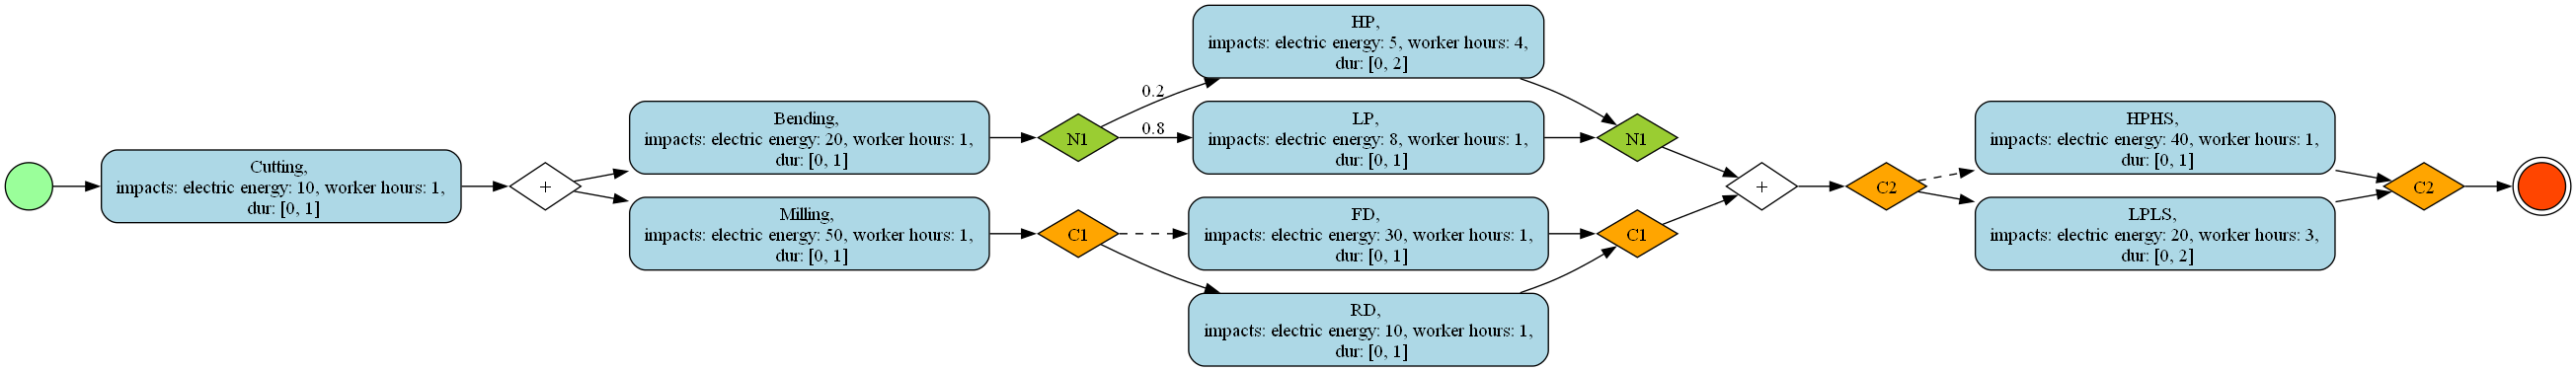

In [8]:
import io
from PIL import Image
from IPython.display import display
display(
    Image.open(
        io.BytesIO(
            pydot_graph.create_png()
            )
    )
)

## Calcolate strategy


Remember to choose an appropriate bound.

In [ ]:

data = {
    'bpmn': bpmn,          
    'bound': [20.0, 20.0], 
    'algo': 'paco',
}
strat = requests.get(
    f'{url}calc_strategy_general',
    json=data,
    headers=headers,
)
if strat.status_code == 200:
    for key, value in strat.json().items():
        print(f"{key}: {value}")
else:
    print(f"Error: {strat.status_code}, {strat.text}")


result: Guaranteed Bound 0:	[142.   9.]
Guaranteed Bound 1:	[138.   9.]
Guaranteed Bound 2:	[154.   8.]
Guaranteed Bound 3:	[158.   7.]
Guaranteed Bound 4:	[122.   9.]
Guaranteed Bound 5:	[118.   9.]
Guaranteed Bound 6:	[138.   7.]
Guaranteed Bound 7:	[134.   8.]

expected_impacts: None
possible_min_solution: [array([141.4,   8.2]), array([137.4,   8.6]), array([153.4,   7. ]), array([157.4,   6.6]), array([121.4,   8.2]), array([117.4,   8.6]), array([137.4,   6.6]), array([133.4,   7. ])]
solutions: [array([141.4,   8.2]), array([137.4,   8.6]), array([153.4,   7. ]), array([157.4,   6.6]), array([121.4,   8.2]), array([117.4,   8.6]), array([137.4,   6.6]), array([133.4,   7. ])]
choices: []
found_strategy_time: 1.188
build_strategy_time: None
time_create_parse_tree: 339.872
time_create_execution_tree: 10.094000000000001
time_evaluate_cei_execution_tree: 0.126
strategy_expected_time: None
time_explain_strategy: None
strategy_tree_time: None


### Strategy step-by-step

### Visualize the strategy trees & excecution trese & explainer trees

#### EXCECUTION TREES

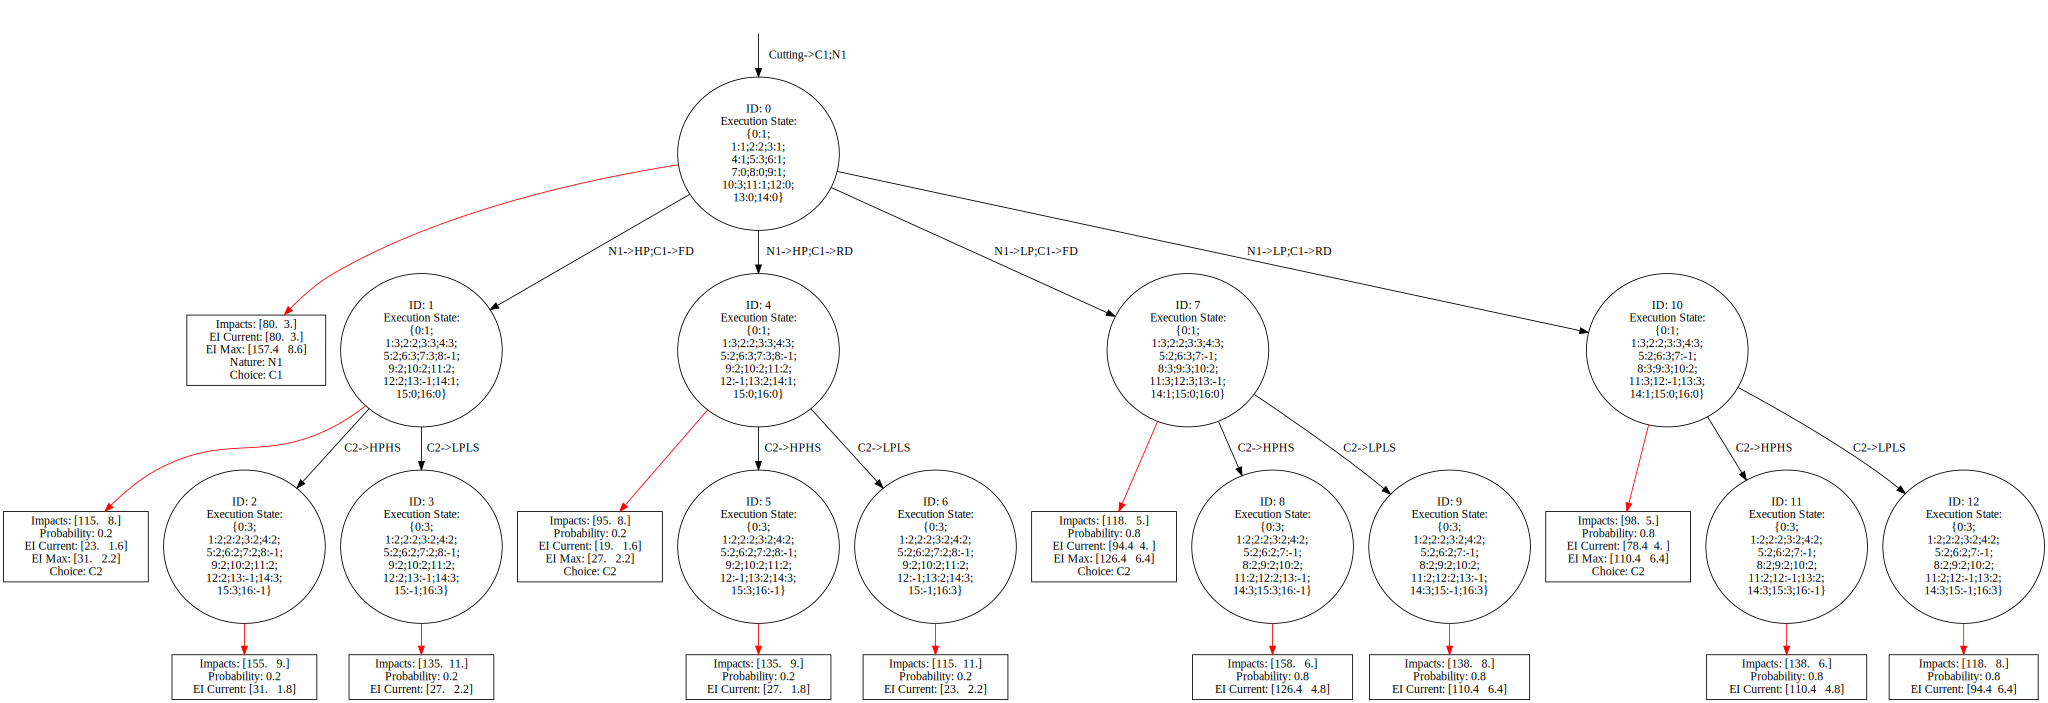

In [10]:
response = requests.get(f'{url}get_execution_tree_state', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

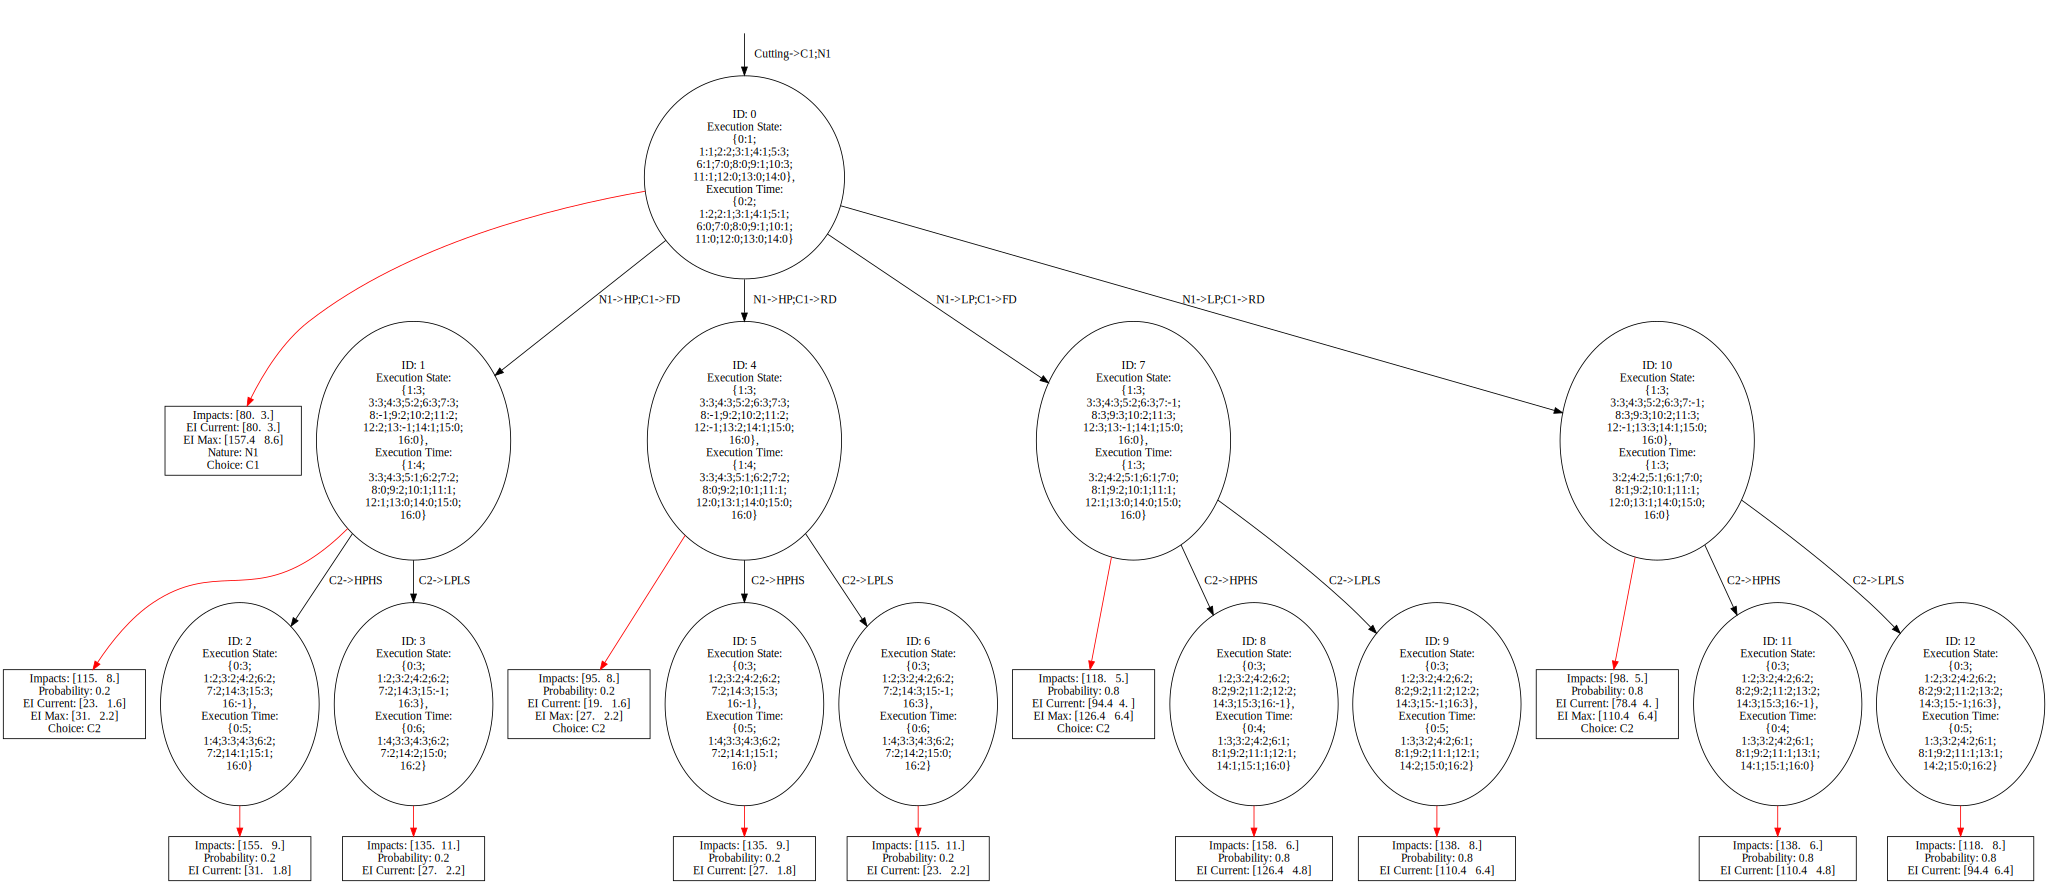

In [11]:
response = requests.get(f'{url}get_execution_tree_state_time', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

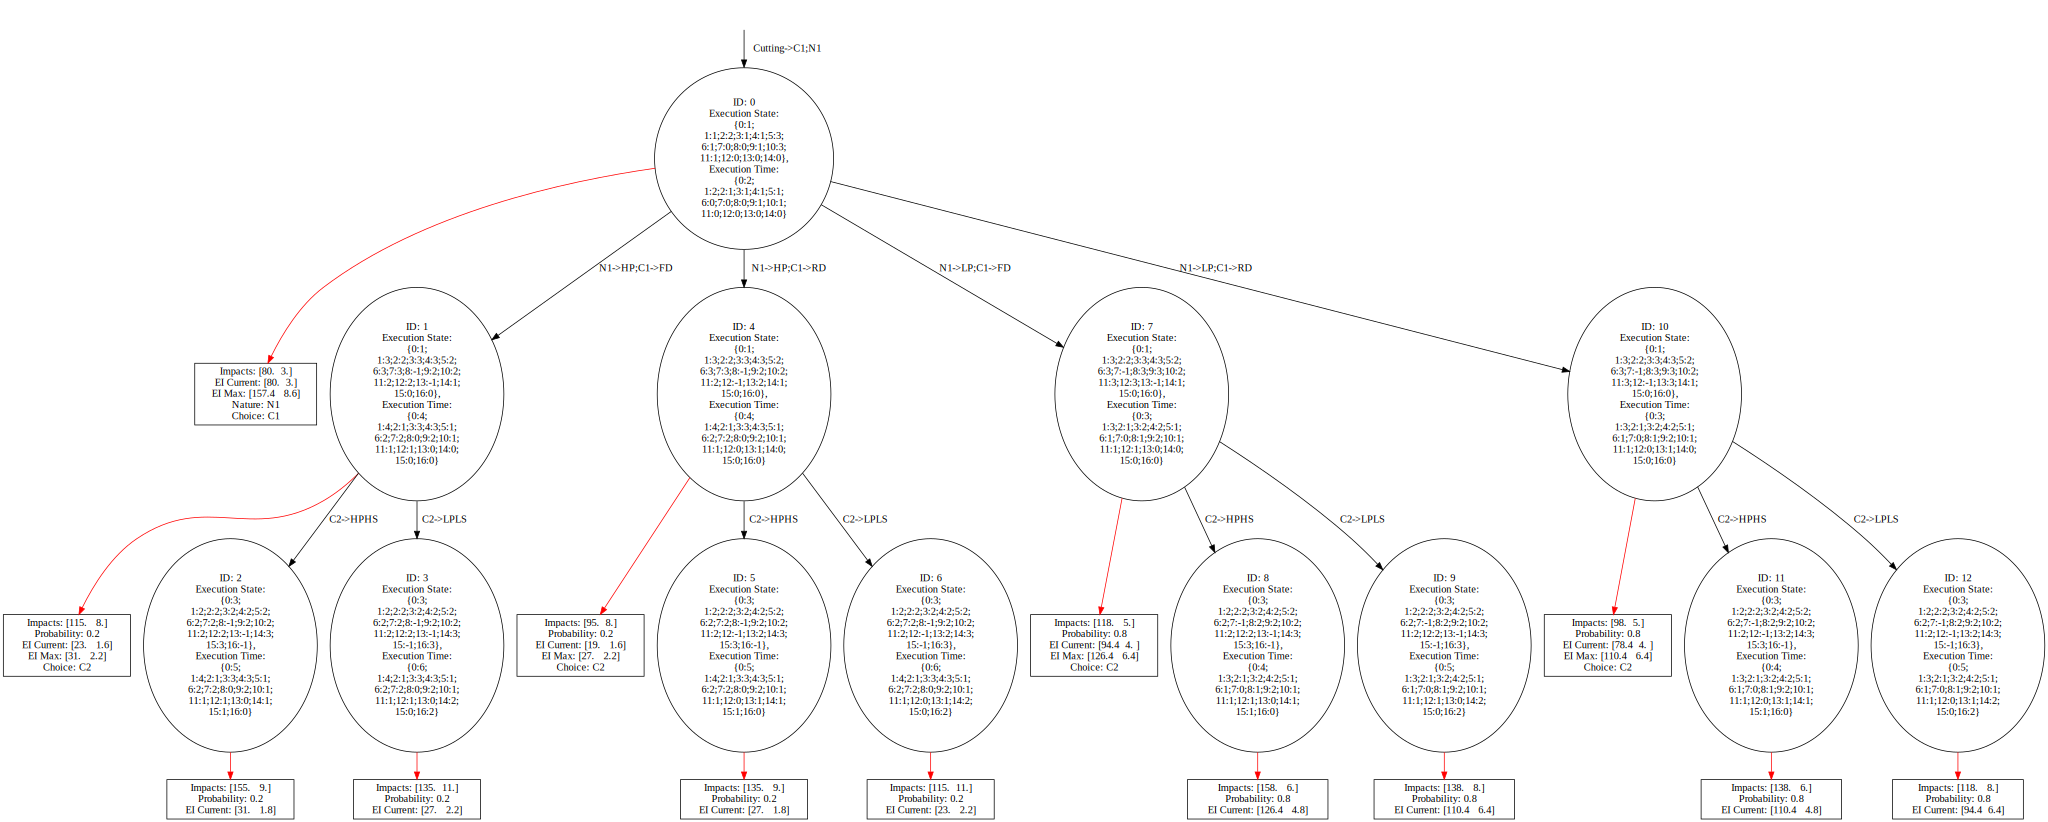

In [12]:
response = requests.get(f'{url}get_execution_tree_state_time_extended', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

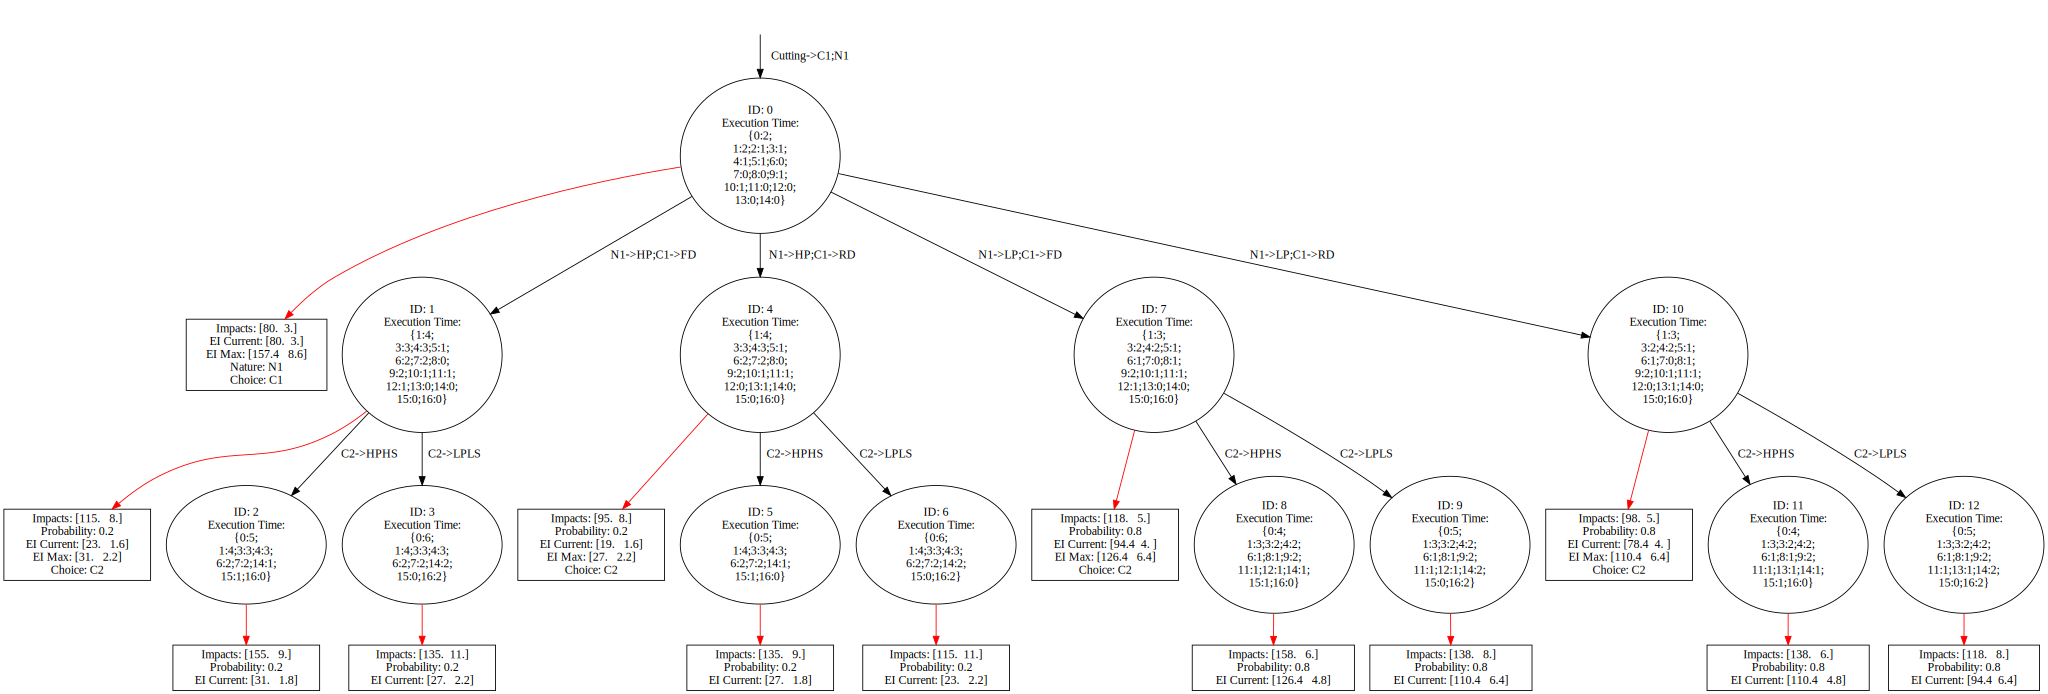

In [13]:
response = requests.get(f'{url}get_execution_tree_time', headers=headers)
if response.status_code == 200:
   display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

#### STRATEGY TREES

In [23]:
response = requests.get(f'{url}get_strategy_tree_state', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 500, Internal Server Error


In [24]:
response = requests.get(f'{url}get_strategy_tree_state_time', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 500, Internal Server Error


In [25]:
response = requests.get(f'{url}get_strategy_tree_state_time_extended', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 500, Internal Server Error


In [26]:
response = requests.get(f'{url}get_strategy_tree_time', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 500, Internal Server Error


#### EXPLAINER TREES

In [27]:
response = requests.get(f'{url}get_explainer_decision_tree', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 500, Internal Server Error


In [28]:
response = requests.get(f'{url}get_explainer_bdd', headers=headers)
if response.status_code == 200:
    display(SVG(response.content))
else:
    print(f"Error: {response.status_code}, {response.text}")

Error: 500, Internal Server Error


## LLM

### Chat with the LMM 

In [ ]:
# If wanted can be used also this predefined prompt that consituates the example found in the paper
# prompt = '''
# Now I have to complete the writing task before 
# having a nature between talking with the publisher or to print the page written.
# Then, I choose between going to the park or continue writing.
# '''
session_id = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(8))
prompt = input("Enter your prompt: ")
data = {
    "session_id": session_id,
    "prompt": prompt,
    "url": input("Enter the URL of the model: "),
    "api_key": getpass.getpass("Enter the API key: "),
    "model": input("Enter the the model: "),
    "temperature": 0.7,
    "verbose": False,
}
response = requests.post(f'{url}invoke_agent', headers=headers, json=data)

if response.status_code == 200:
    print(response.json()['response'])
else:
    print(f"Error: {response.status_code}")
    print(f"Response: {response.text}")

### Get Chat History

In [ ]:
response = requests.get(f'{url}get_chat_history', headers=headers, params={"session_id": session_id})

if response.status_code == 200:
    print(response.json()['chat_history'])
else:
    print(f"Error: {response.status_code}")
    print(f"Response: {response.text}")